<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Predicting-Hospital-Readmission-for-Diabetic-Patients" data-toc-modified-id="Predicting-Hospital-Readmission-for-Diabetic-Patients-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Predicting Hospital Readmission for Diabetic Patients</a></span><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Background</a></span></li></ul></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Cleaning</a></span><ul class="toc-item"><li><span><a href="#Number-of-Procedures:" data-toc-modified-id="Number-of-Procedures:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Number of Procedures:</a></span></li><li><span><a href="#Modeling:" data-toc-modified-id="Modeling:-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Modeling:</a></span></li></ul></li></ul></div>

# Predicting Hospital Readmission for Diabetic Patients

## Background
According to a [study](https://care.diabetesjournals.org/content/24/11/1936) published by the American Diabetes Association in 2001, the number of Americans diagnosed with diabetes is projected to increase by 165% by 2050. The study suggests this increase, from 11 million to 29 million affected individuals, would be most significant in individuals >= 75 years old.
<br>

While this increase itself is concerning when viewed from a human health perspective, it also represents additional logistical complications for the US healthcare system which should also be considered. The unfortunate reality is that hospitals possess limited resources in space, personnel, and time. As hospital costs rise as a product of increasing rates of Diabetes in the population, more hospital resources are required to accomodate patient health needs. The monetary cost of these resources is passed on to insurance companies, and ultimately to the public.

![image](img/F1.large.jpg)
Figure:
Percentage breakdowns of the projected increase in the total number of people with diagnosed diabetes due to population growth, increasing prevalence rates, and demographic changes for the years 2010, 2025, and 2050 (most likely scenario). □, Population growth; [cjs2106], increasing prevalence rates; ▪ demographic changes. [Source](https://care.diabetesjournals.org/content/24/11/1936.article-info)

<br>

When considering an approach to tackling this issue, an old addage may ring true: "An ounce of prevention is worth a pound of cure." By studying available medical records for Diabetic patients, we might be able to better determine presenting symptoms that might indicate that a patient is "at risk" for readmission. By identifying these symptoms (or collections of symptoms) using Artificial Intelligence, physicians may be better equipped to effectively treat underlying health issues in Diabetic patients, improving long-term patient prognosis. By providing more effective treatment options, we would hope to decrease hospital readmission rates in Diabetic patients worldwide.

<br>

In this investigation, we'll use a [dataset](http://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) representing 10 years (1999-2008) of clinical care records from 130 US hoptials. The dataset, contains ~100,000 patient encounters meeting the following criteria:

1. It is an inpatient encounter (a hospital admission).
2. It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
3. The length of stay was at least 1 day and at most 14 days.
4. Laboratory tests were performed during the encounter.
5. Medications were administered during the encounter.

<br>

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import keras
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers
from scipy import stats
import scipy

sns.set_palette('Blues')

from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


Now that we've loaded some libraries to help us explore the data, let's import the dataset. The goal of this exercise is to take a peek at the data contained within our dataset. We must identify our input variables as well as the target variable. We'll seek to understand distribution, formatting, and to begin to explore how the features are related.

We'll use this understanding to explore what patient health factors are the strongest indicators of hospital readmission for diabetic patients.

In [2]:
data = pd.read_csv('dataset_diabetes/diabetic_data.csv', delimiter=',')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


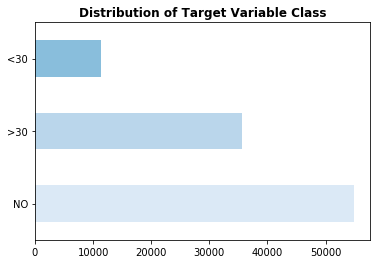

In [6]:
fig = plt.figure(figsize=(6,4))
plt.title('Distribution of Target Variable Class', fontweight='semibold')
pd.value_counts(data.readmitted).plot.barh()

fig.savefig('img/target_var_distribution.png')

Now, let's take a look at all of the columns in the dataset. Our goal will be first to evaluate whether the feature is significant. In other words, we want to answer the question: "Does this variable have an impact on determining whether a patient will be readmitted to the hospital?".

To answer this question, we'll explore the data contained within our columns, consulting the provided [data dictionary](https://www.hindawi.com/journals/bmri/2014/781670/tab1/). 

In [7]:
print(data.columns)

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


According to the data dictionary linked above, there are several columns containing missing data. Before determining how best to handle these missing values, let's identify their presence ourselves to verify the information, examine the unique values contained within each column, and finally make a determination as to whether we could/should attempt to utilize the data within these columns.

In [8]:
data.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [9]:
# Uncomment and run cell contents to view value counts for each feature:
#for col in data.columns:
#    print(col)
#    print(f'{(data[col].value_counts())}')

Based on the information contained within the data dictionary, we'll begin by eliminating features that do not logically contribute to readmission, such as the unique encounter ID, a unique identifier of a patient visit.

In [10]:
data.drop(['encounter_id'], axis=1, inplace=True)
data.head(3)

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,...,No,No,No,No,No,No,No,No,No,NO
1,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,...,No,No,No,No,No,No,No,No,Yes,NO


**Patient Number:**

Before determining whether this feature might provide value, let's first examine the number of unique patient numbers in the dataset to determine the number of duplicate patient numbers in the dataset.

In [11]:
print(len(data.patient_nbr.unique()))
print(len(data.patient_nbr))
print(f'There are {len(data.patient_nbr) - len(data.patient_nbr.unique())} duplicate patient numbers in the dataset.') 

71518
101766
There are 30248 duplicate patient numbers in the dataset.


Based on this result, we can determine that at least some of the patients contained within the dataset have more than one recorded visit. Let's visualize some of these records. Based on our analysis, we may seek to investigate whether some/all duplicate records should be used, or how symptoms change in severity upon readmission and so on.

In [12]:
patient_88785891 = data.loc[lambda x: x['patient_nbr'] == 88785891]
#print(patient_88785891.info(), '\n')
#print('-'*100, '\n')
print(patient_88785891.describe())

       patient_nbr  admission_type_id  discharge_disposition_id  \
count         40.0          40.000000                 40.000000   
mean    88785891.0           1.650000                  1.700000   
std            0.0           0.622237                  1.897367   
min     88785891.0           1.000000                  1.000000   
25%     88785891.0           1.000000                  1.000000   
50%     88785891.0           2.000000                  1.000000   
75%     88785891.0           2.000000                  1.000000   
max     88785891.0           3.000000                  7.000000   

       admission_source_id  time_in_hospital  num_lab_procedures  \
count            40.000000         40.000000           40.000000   
mean              6.925000          3.175000           39.825000   
std               0.474342          2.061708           23.984918   
min               4.000000          1.000000            1.000000   
25%               7.000000          1.750000           1

In [13]:
data.drop(['patient_nbr'], axis=1, inplace=True)

**Race:**

Some medical conditions, such as sickle cell anemia, affect members of specific races differently. After cleaning data, we may wish to examine readmission rates based on racial identity, to determine if any observations regarding treatment efficacy and/or patient prognosis can be made.

In [14]:
data.race.value_counts()

Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

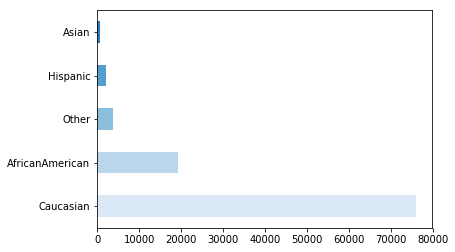

In [16]:
fig = plt.figure(figsize=(6,4))
data.loc[data.race == '?', 'race'] = 'Other'
pd.value_counts(data['race']).plot.barh()
fig.savefig('img/dataset_ethnicity_counts')

Since Caucaisians and African Americans comprise most of the dataset, let's review their distributions in readmission.

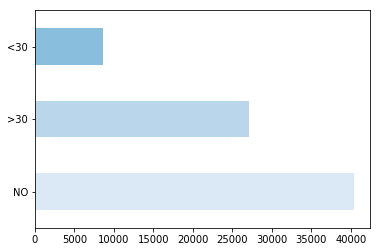

In [17]:
df_cau = data.loc[data['race']=='Caucasian']
df_cau.readmitted.value_counts().plot(kind='barh')

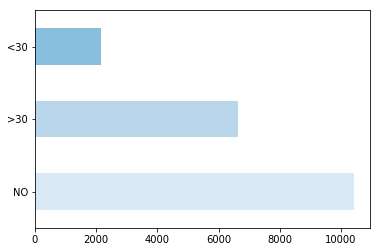

In [18]:
df_aa = data.loc[data['race']=='AfricanAmerican']
df_aa.readmitted.value_counts().plot(kind='barh')

In [19]:
#data.loc[data['race']=='AfricanAmerican'].value_counts().plot(kind='barh')

In [20]:
#data.drop(['race'], axis=1, inplace=True)
#data.columns

In [21]:
race_cols = {}

for race in data.race.unique():
    key = f"race_{race}"
    value = race.lower()
    race_cols[key] = value

race_cols

data = pd.get_dummies(data, columns=['race'])
data.rename(mapper=race_cols, axis=1).head()

,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,africanamerican,asian,caucasian,hispanic,other
0,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,...,No,No,No,No,NO,0,0,1,0,0
1,Female,[10-20),?,1,1,7,3,?,?,59,...,No,No,Ch,Yes,>30,0,0,1,0,0
2,Female,[20-30),?,1,1,7,2,?,?,11,...,No,No,No,Yes,NO,1,0,0,0,0
3,Male,[30-40),?,1,1,7,2,?,?,44,...,No,No,Ch,Yes,NO,0,0,1,0,0
4,Male,[40-50),?,1,1,7,1,?,?,51,...,No,No,Ch,Yes,NO,0,0,1,0,0


**Note:**

> Because limited data is available, we will drop all newly created one-hot-encoded race columns aside from 'africanamerican' and 'caucasian' from consideration. It should be noted that this approach may result in an outcome that is not representative of parts of the US population.
>
> In a future investigation (and in any investigation that could affect clinical procedures), additional data should be acquired in order to properly evaluate potential underlying correlations to patient prognosis and/or hospital readmission.

In [22]:
data = data.drop(columns=(['race_Asian', 'race_Hispanic', 'race_Other']), axis=1)
data.columns

Index(['gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'race_AfricanAmerican', 'race_Caucasian'],
      dtype='object')

**Gender:**

In [23]:
data.gender.value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [24]:
data.loc[data.gender == 'Unknown/Invalid']

,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,race_AfricanAmerican,race_Caucasian
30506,Unknown/Invalid,[70-80),?,3,1,1,1,?,Cardiology,5,...,No,No,No,No,No,Ch,Yes,NO,0,0
75551,Unknown/Invalid,[60-70),?,1,1,7,1,CP,?,38,...,No,No,No,No,No,No,No,NO,0,0
82573,Unknown/Invalid,[70-80),?,1,22,7,8,CP,?,59,...,No,No,No,No,No,Ch,Yes,NO,0,0


In [25]:
data = data[data['gender'] != 'Unknown/Invalid']

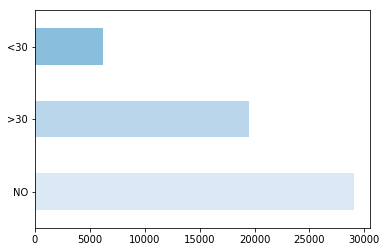

In [26]:
df_female = data.loc[data['gender']=='Female']
df_female.readmitted.value_counts().plot(kind='barh')

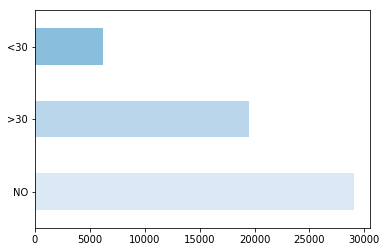

In [27]:
df_male = data.loc[data['gender']=='Female']
df_male.readmitted.value_counts().plot(kind='barh')

In [28]:
data.gender.replace({'Male': 0, 'Female': 1}, inplace=True)
display(data.gender.value_counts())
display(data.columns)

1    54708
0    47055
Name: gender, dtype: int64

Index(['gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'race_AfricanAmerican', 'race_Caucasian'],
      dtype='object')

**Age:**

In [29]:
data.age.value_counts()

[70-80)     26066
[60-70)     22482
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

In [30]:
data.age = data.age.str.replace("[", "").str[0].astype(int)
data.age.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

**Weight:**

In [31]:
data.weight.value_counts()

?            98566
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

In [32]:
data.drop('weight', axis=1, inplace=True)
#data.head()

**Admission Type:**

> 1.	Personal physician referral (or self-referral)
2.	This hospital's clinic referral
3.	HMO referral
4.	Transfer from another hospital
5.	Transfer from nursing home
6.	Transfer from another healthcare facility
7.	This hospital's Emergency Room
8.	Court or law enforcement
9.	Information not available

In [33]:
data.admission_type_id.value_counts()

1    53988
3    18868
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64

In [34]:
# One Hot Encode:

In [35]:
dums = pd.get_dummies(data.admission_type_id)
dums.rename({1: 'ad_id_1', 2: 'ad_id_2', 3: 'ad_id_3', 4: 'ad_id_4', \
             5: 'ad_id_5', 6: 'ad_id_6', 7: 'ad_id_7', 8: 'ad_id_8'}, axis=1, inplace=True)

In [36]:
for col in dums:
    print(col, '\n', dums[col].value_counts())

ad_id_1 
 1    53988
0    47775
Name: ad_id_1, dtype: int64
ad_id_2 
 0    83283
1    18480
Name: ad_id_2, dtype: int64
ad_id_3 
 0    82895
1    18868
Name: ad_id_3, dtype: int64
ad_id_4 
 0    101753
1        10
Name: ad_id_4, dtype: int64
ad_id_5 
 0    96978
1     4785
Name: ad_id_5, dtype: int64
ad_id_6 
 0    96472
1     5291
Name: ad_id_6, dtype: int64
ad_id_7 
 0    101742
1        21
Name: ad_id_7, dtype: int64
ad_id_8 
 0    101443
1       320
Name: ad_id_8, dtype: int64


In [37]:
# Dropping low variance columns after one-hot-encoding:

In [38]:
dums.drop(['ad_id_4', 'ad_id_5', 'ad_id_6', 'ad_id_7', 'ad_id_8'], axis=1, inplace=True)

data = pd.concat([data, dums], axis=1)
data.columns

Index(['gender', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'race_AfricanAmerican', 'race_Caucasian', 'ad_id_1', 'ad_id_2',
       'ad_id_3'],
      dtype='object')

**Discharge Disposition:**

In [39]:
data.discharge_disposition_id.value_counts()

1     60232
3     13954
6     12902
18     3691
2      2128
22     1992
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

In [40]:
data.discharge_disposition_id.dtype

dtype('int64')

In order to prepare the data for discharge disposition for modeling, we will need to one-hot-encode the unique column values. However, because there are 29 unique column values representing where patients were discharged (most with low population), the increase in dimensionality as a result of the newly created columns is not worth the relatively small gain in information.

In order to retain as much of the data as possible, we can break down the discharge dispostion into two broad categories: 'Discharged to home' and 'referred for further treatment'.

In [41]:
#data['discharge_other'] = data['discharge_disposition_id'].apply(lambda x: 1 if x!=1 else 0)

In [42]:
data['discharge_home'] = data['discharge_disposition_id'].apply(lambda x: 1 if x==1 else 0)
data.discharge_home.value_counts() #1 represents dicharged to home

1    60232
0    41531
Name: discharge_home, dtype: int64

In [43]:
data.drop(['discharge_disposition_id'], axis=1, inplace=True)

**Admission Source:**

> admission_source_id,description
    1. Physician Referral
    2. Clinic Referral
    3. HMO Referral
    4. Transfer from a hospital
    5. Transfer from a Skilled Nursing Facility (SNF)
    6. Transfer from another health care facility
    7. Emergency Room
    8. Court/Law Enforcement
    9. Not Available
    10. Transfer from critial access hospital
    11. Normal Delivery
    12. Premature Delivery
    13. Sick Baby
    14. Extramural Birth
    15. Not Available
    17. NULL
    18. Transfer From Another Home Health Agency
    19. Readmission to Same Home Health Agency
    20. Not Mapped
    21. Unknown/Invalid
    22. Transfer from hospital inpt/same fac reslt in a sep claim
    23. Born inside this hospital
    24. Born outside this hospital
    25. Transfer from Ambulatory Surgery Center
    26. Transfer from Hospice
    

Admission Source ID and Admission Type have significant overlap (and verified multicollinearity prior to modeling). In order to account for multicollinearity between these features, admission source id will be discarded from the dataset.

In [44]:
data.admission_source_id.value_counts()

7     57492
1     29564
17     6781
4      3187
6      2264
2      1104
5       855
3       187
20      161
9       125
8        16
22       12
10        8
11        2
14        2
25        2
13        1
Name: admission_source_id, dtype: int64

In [45]:
data.drop(['admission_source_id'], axis=1, inplace=True)
data.columns

Index(['gender', 'age', 'admission_type_id', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'race_AfricanAmerican', 'race_Caucasian', 'ad_id_1', 'ad_id_2',
       'ad_id_3', 'discharge_home'],
      dtype='object')

**Time in Hospital:**
- measured in days

In [46]:
data.time_in_hospital.value_counts()

3     17756
2     17224
1     14206
4     13924
5      9966
6      7539
7      5859
8      4390
9      3002
10     2342
11     1855
12     1448
13     1210
14     1042
Name: time_in_hospital, dtype: int64

In [47]:
data.time_in_hospital.describe()

count    101763.000000
mean          4.396018
std           2.985092
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          14.000000
Name: time_in_hospital, dtype: float64

In [48]:
#data.time_in_hospital.nlargest(n=8)

Text(0.5, 1.0, 'Distribution of Days Spent in Hospital')

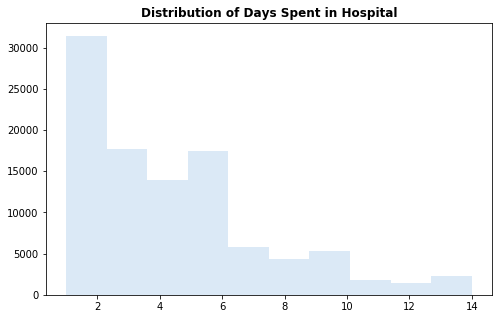

In [49]:
fig, ax = plt.figure(figsize=(8,5)), data.time_in_hospital.hist()
ax.grid(False)
ax.set_title('Distribution of Days Spent in Hospital', fontweight='semibold')

In [50]:
#Attempting to normalize distribution of days spent in hospital

Text(0.5, 1.0, 'Distribution of Days Spent in Hospital (log+1)')

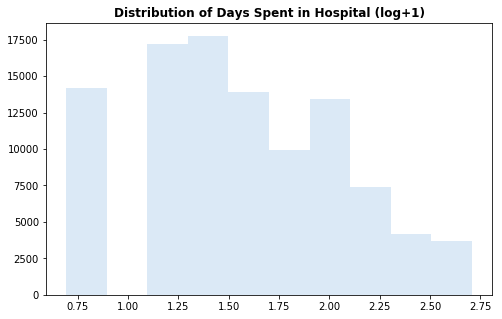

In [51]:
data['log_add1_time_in_hospital'] = np.log(data.time_in_hospital + 1)

fig, ax = plt.figure(figsize=(8,5)), data.log_add1_time_in_hospital.hist()
ax.grid(False)
ax.set_title('Distribution of Days Spent in Hospital (log+1)', fontweight='semibold')

In [52]:
data.drop(['time_in_hospital'], axis=1, inplace=True)

Payer code:

In [53]:
data.payer_code.value_counts()

?     40255
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2531
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64

In [54]:
data.drop(['payer_code'], axis=1, inplace=True)
data.head()

,gender,age,admission_type_id,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,change,diabetesMed,readmitted,race_AfricanAmerican,race_Caucasian,ad_id_1,ad_id_2,ad_id_3,discharge_home,log_add1_time_in_hospital
0,1,0,6,Pediatrics-Endocrinology,41,0,1,0,0,0,...,No,No,NO,0,1,0,0,0,0,0.693147
1,1,1,1,?,59,0,18,0,0,0,...,Ch,Yes,>30,0,1,1,0,0,1,1.386294
2,1,2,1,?,11,5,13,2,0,1,...,No,Yes,NO,1,0,1,0,0,1,1.098612
3,0,3,1,?,44,1,16,0,0,0,...,Ch,Yes,NO,0,1,1,0,0,1,1.098612
4,0,4,1,?,51,0,8,0,0,0,...,Ch,Yes,NO,0,1,1,0,0,1,0.693147


Medical Specialty:

In [55]:
data.medical_specialty.value_counts()

?                                    49947
InternalMedicine                     14635
Emergency/Trauma                      7565
Family/GeneralPractice                7440
Cardiology                            5351
Surgery-General                       3099
Nephrology                            1613
Orthopedics                           1400
Orthopedics-Reconstructive            1233
Radiologist                           1140
Pulmonology                            871
Psychiatry                             854
Urology                                685
ObstetricsandGynecology                671
Surgery-Cardiovascular/Thoracic        652
Gastroenterology                       564
Surgery-Vascular                       533
Surgery-Neuro                          468
PhysicalMedicineandRehabilitation      391
Oncology                               348
Pediatrics                             254
Hematology/Oncology                    207
Neurology                              203
Pediatrics-

In [56]:
data.drop(['medical_specialty'], axis=1, inplace=True)
data.columns

Index(['gender', 'age', 'admission_type_id', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'race_AfricanAmerican', 'race_Caucasian', 'ad_id_1', 'ad_id_2',
       'ad_id_3', 'discharge_home', 'log_add1_time_in_hospital'],
      dtype='object')

Number of Lab Procedures:

In [57]:
data.num_lab_procedures.value_counts()

1      3208
43     2804
44     2496
45     2376
38     2212
40     2201
46     2189
41     2117
42     2113
47     2106
39     2101
37     2079
49     2066
48     2058
36     1962
51     1925
50     1924
35     1907
54     1888
56     1839
52     1838
55     1836
53     1802
57     1747
58     1708
34     1677
61     1638
59     1623
60     1610
63     1450
       ... 
89       73
90       65
91       61
93       56
92       48
95       46
94       45
97       31
96       28
98       26
101      13
100      13
99        9
102       8
103       6
105       6
106       5
109       4
108       4
111       3
113       3
104       3
114       2
126       1
132       1
107       1
118       1
129       1
120       1
121       1
Name: num_lab_procedures, Length: 118, dtype: int64

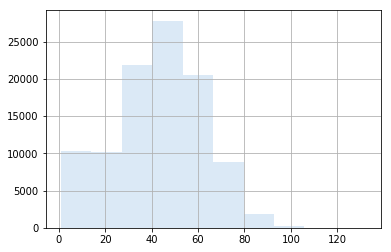

In [58]:
data.num_lab_procedures.hist()

## Number of Procedures:

In [59]:
data.num_procedures.value_counts()

0    46652
1    20741
2    12716
3     9443
6     4954
4     4180
5     3077
Name: num_procedures, dtype: int64

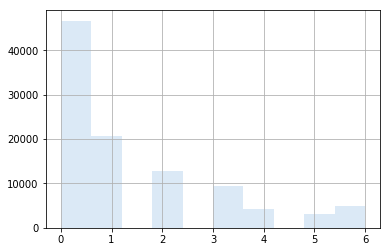

In [60]:
data.num_procedures.hist()

In [61]:
#Attempting to normalize:

In [62]:
#data.loc[data.num_procedures >1, 'num_procedures'] = 2
#pd.value_counts(data['race']).plot.bar()

In [63]:
#data['log_num_procedures_plus1'] = np.log(data.num_procedures+1)
#data.log_num_procedures_plus1.hist()

In [64]:
#data['boxcox_num_procedures'] = scipy.stats.boxcox(data.num_procedures)
#data.boxcox_num_procedures.hist()

**Number of Medications:**

In [65]:
data.num_medications.value_counts()

13    6086
12    6004
11    5795
15    5792
14    5707
16    5430
10    5346
17    4919
9     4913
18    4523
8     4353
19    4078
20    3691
7     3484
21    3229
22    2867
6     2698
23    2426
24    2109
5     2017
25    1888
26    1608
27    1432
4     1417
28    1233
29    1000
3      900
30     849
31     712
32     623
      ... 
45      88
47      74
49      61
48      60
50      55
52      54
51      43
53      40
56      37
54      33
55      32
57      26
58      25
60      23
59      20
62      15
63      14
61      14
65      12
64       8
68       7
67       7
69       5
66       5
72       3
70       2
75       2
74       1
79       1
81       1
Name: num_medications, Length: 75, dtype: int64

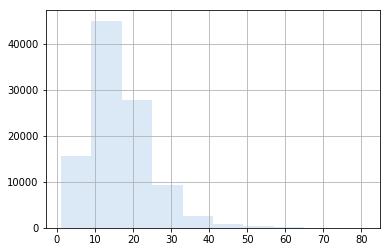

In [66]:
data.num_medications.hist()

Number of Outpatient Visits:

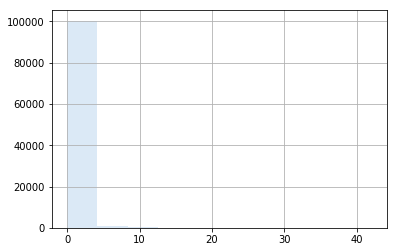

In [67]:
data.number_outpatient.value_counts()
data.number_outpatient.hist()

Number of Emergency visits:

Because the vast majority of the data shows patients have either 0 or 1 emergency visits, we can reduce recast the column to boolean yes/no.

In [68]:
data.number_emergency.value_counts()

0     90380
1      7677
2      2042
3       725
4       374
5       192
6        94
7        73
8        50
10       34
9        33
11       23
13       12
12       10
22        6
18        5
16        5
19        4
20        4
14        3
15        3
21        2
25        2
76        1
54        1
24        1
28        1
29        1
37        1
42        1
46        1
64        1
63        1
Name: number_emergency, dtype: int64

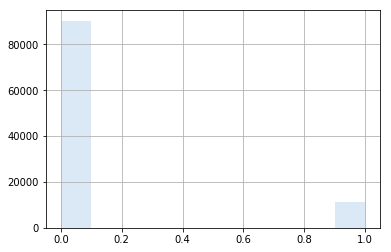

In [69]:
data.loc[data.number_emergency != 0, 'number_emergency'] = 1
data.number_emergency.hist()

Number of Inpatient Visits:

Because the vast majority of the data shows patients have either 0 or 1 inpatient visits, we can reduce recast the column to boolean yes/no.

In [70]:
data.number_inpatient.value_counts()

0     67627
1     19521
2      7566
3      3411
4      1622
5       812
6       480
7       268
8       151
9       111
10       61
11       49
12       34
13       20
14       10
15        9
16        6
19        2
17        1
18        1
21        1
Name: number_inpatient, dtype: int64

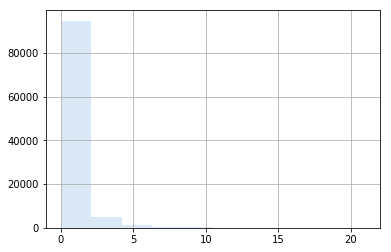

In [71]:
data.number_inpatient.hist()

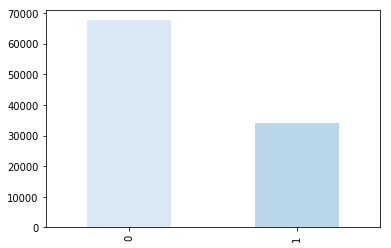

In [72]:
data.loc[data.number_inpatient != 0, 'number_inpatient'] = 1

pd.value_counts(data['number_inpatient']).plot.bar()

Diagnosis 1:

In [73]:
data.diag_1.value_counts()

428       6862
414       6580
786       4016
410       3614
486       3508
427       2766
491       2275
715       2151
682       2042
434       2028
780       2019
996       1967
276       1889
38        1688
250.8     1680
599       1595
584       1520
V57       1207
250.6     1183
518       1115
820       1082
577       1057
493       1056
435       1016
562        989
574        965
296        896
560        876
250.7      871
250.13     851
          ... 
988          1
976          1
640          1
471          1
97           1
V07          1
827          1
543          1
V43          1
838          1
391          1
911          1
318          1
363          1
373          1
885          1
939          1
605          1
145          1
804          1
V70          1
834          1
906          1
477          1
V67          1
704          1
915          1
365          1
372          1
389          1
Name: diag_1, Length: 717, dtype: int64

In [74]:
data.diag_1.unique()

array(['250.83', '276', '648', '8', '197', '414', '428', '398', '434',
       '250.7', '157', '518', '999', '410', '682', '402', '737', '572',
       'V57', '189', '786', '427', '996', '277', '584', '462', '473',
       '411', '174', '486', '998', '511', '432', '626', '295', '196',
       '250.6', '618', '182', '845', '423', '808', '250.4', '722', '403',
       '250.11', '784', '707', '440', '151', '715', '997', '198', '564',
       '812', '38', '590', '556', '578', '250.32', '433', 'V58', '569',
       '185', '536', '255', '250.13', '599', '558', '574', '491', '560',
       '244', '250.03', '577', '730', '188', '824', '250.8', '332', '562',
       '291', '296', '510', '401', '263', '438', '70', '250.02', '493',
       '642', '625', '571', '738', '593', '250.42', '807', '456', '446',
       '575', '250.41', '820', '515', '780', '250.22', '995', '235',
       '250.82', '721', '787', '162', '724', '282', '514', 'V55', '281',
       '250.33', '530', '466', '435', '250.12', 'V53', '789', '

Diagnosis 2:

In [75]:
data.diag_2.value_counts()

276       6752
428       6662
250       6071
427       5036
401       3736
496       3305
599       3288
403       2823
414       2650
411       2565
250.02    2074
707       1999
585       1871
584       1649
491       1545
250.01    1523
285       1520
780       1491
425       1434
682       1433
486       1379
518       1355
424       1071
413       1042
250.6      895
493        881
305        702
786        644
280        606
998        571
          ... 
130          1
917          1
35           1
871          1
E854         1
962          1
232          1
268          1
E980         1
52           1
99           1
506          1
942          1
863          1
46           1
E813         1
115          1
V69          1
111          1
523          1
137          1
912          1
195          1
E915         1
894          1
580          1
V13          1
843          1
E826         1
E965         1
Name: diag_2, Length: 749, dtype: int64

Diagnosis 3:

In [76]:
data.diag_3.value_counts()

250       11555
401        8288
276        5175
428        4577
427        3955
414        3664
496        2605
403        2357
585        1992
272        1969
599        1941
?          1423
V45        1389
250.02     1369
707        1360
780        1334
285        1200
425        1136
250.6      1080
424        1063
584         963
305         924
250.01      915
682         887
518         854
41          727
493         694
278         680
530         625
786         584
          ...  
732           1
755           1
524           1
115           1
837           1
475           1
942           1
952           1
27            1
175           1
387           1
E915          1
195           1
980           1
E825          1
972           1
158           1
49            1
944           1
E813          1
148           1
E886          1
657           1
E904          1
875           1
217           1
365.44        1
951           1
884           1
E826          1
Name: diag_3, Length: 79

In [77]:
diag_3_missing = data.loc[lambda x: x['diag_3'] == '?']
print(f'There are {len(diag_3_missing)} missing values for diag_3.')
print(f'There are {len(data.diag_3)} total values in the dataset for diag_3.') 

There are 1423 missing values for diag_3.
There are 101763 total values in the dataset for diag_3.


In [78]:
#Drop, cast to column mode? Very unsure about assigning to mode
data.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)
data.columns

Index(['gender', 'age', 'admission_type_id', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'race_AfricanAmerican', 'race_Caucasian', 'ad_id_1', 'ad_id_2',
       'ad_id_3', 'discharge_home', 'log_add1_time_in_hospital'],
      dtype='object')

Number of Diagnoses:

In [79]:
data.number_diagnoses.value_counts()

9     49473
5     11392
8     10616
7     10393
6     10161
4      5536
3      2835
2      1023
1       219
16       45
10       17
13       16
11       11
15       10
12        9
14        7
Name: number_diagnoses, dtype: int64

Max Glucose:

In [80]:
data.max_glu_serum.value_counts()

None    96417
Norm     2597
>200     1485
>300     1264
Name: max_glu_serum, dtype: int64

In [81]:
data.drop(['max_glu_serum'], axis=1, inplace=True)
data.columns

Index(['gender', 'age', 'admission_type_id', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'race_AfricanAmerican', 'race_Caucasian', 'ad_id_1', 'ad_id_2',
       'ad_id_3', 'discharge_home', 'log_add1_time_in_hospital'],
      dtype='object')

**A1c Test Result:**

In [82]:
data.A1Cresult.value_counts()

None    84745
>8       8216
Norm     4990
>7       3812
Name: A1Cresult, dtype: int64

In [83]:
data.drop(['A1Cresult'], axis=1, inplace=True)

**Change of Medications:**

In [84]:
data.change.value_counts()

No    54754
Ch    47009
Name: change, dtype: int64

In [85]:
data.change.replace({'No': 0, 'Ch': 1}, inplace=True)
data.change.value_counts() #1 represents a change in medication

0    54754
1    47009
Name: change, dtype: int64

**24 Features for medications:**

In [86]:
data.diabetesMed.value_counts()

Yes    78361
No     23402
Name: diabetesMed, dtype: int64

In [87]:
data.diabetesMed.replace({'No': 0, 'Yes': 1}, inplace=True)
data.diabetesMed.unique() #1 represents medicine was replaced

array([0, 1])

In [88]:
print(data.columns)

Index(['gender', 'age', 'admission_type_id', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'race_AfricanAmerican', 'race_Caucasian', 'ad_id_1', 'ad_id_2',
       'ad_id_3', 'discharge_home', 'log_add1_time_in_hospital'],
      dtype='object')


In [89]:
#data = pd.get_dummies(data, columns=(data.columns[17:40]))
#data.columns

In [90]:
print(data.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101763 entries, 0 to 101765
Data columns (total 43 columns):
gender                       101763 non-null int64
age                          101763 non-null int64
admission_type_id            101763 non-null int64
num_lab_procedures           101763 non-null int64
num_procedures               101763 non-null int64
num_medications              101763 non-null int64
number_outpatient            101763 non-null int64
number_emergency             101763 non-null int64
number_inpatient             101763 non-null int64
number_diagnoses             101763 non-null int64
metformin                    101763 non-null object
repaglinide                  101763 non-null object
nateglinide                  101763 non-null object
chlorpropamide               101763 non-null object
glimepiride                  101763 non-null object
acetohexamide                101763 non-null object
glipizide                    101763 non-null object
glyburide      

**Readmitted:**

The target variable of the dataset, 'readmitted' will be placed into a separate DataFrame.

In [91]:
data.readmitted.value_counts()

NO     54861
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [92]:
y_two = pd.DataFrame(data, columns=['readmitted'])
y_two.readmitted.value_counts()

NO     54861
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [93]:
#y = data.readmitted
y = pd.get_dummies(data.readmitted)
data.drop(['readmitted'], axis=1, inplace=True)
y.head()

,<30,>30,NO
0,0,0,1
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1


In [94]:
#y_three = y_two.readmitted.replace({'NO': 0, '<30': 1, '>30': 1})
#y_three.value_counts()

In [95]:
data.drop(columns=['repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', \
         'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', \
         'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', \
         'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', \
         'metformin-rosiglitazone', 'metformin-pioglitazone'], axis=1, inplace=True)
data.columns

Index(['gender', 'age', 'admission_type_id', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'metformin',
       'insulin', 'change', 'diabetesMed', 'race_AfricanAmerican',
       'race_Caucasian', 'ad_id_1', 'ad_id_2', 'ad_id_3', 'discharge_home',
       'log_add1_time_in_hospital'],
      dtype='object')

In [96]:
#data.select_dtypes(include=['object'])

In [97]:
data = pd.get_dummies(data, columns=(['metformin', 'insulin']))
data.columns

Index(['gender', 'age', 'admission_type_id', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'change',
       'diabetesMed', 'race_AfricanAmerican', 'race_Caucasian', 'ad_id_1',
       'ad_id_2', 'ad_id_3', 'discharge_home', 'log_add1_time_in_hospital',
       'metformin_Down', 'metformin_No', 'metformin_Steady', 'metformin_Up',
       'insulin_Down', 'insulin_No', 'insulin_Steady', 'insulin_Up'],
      dtype='object')

In [98]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101763 entries, 0 to 101765
Data columns (total 27 columns):
gender                       101763 non-null int64
age                          101763 non-null int64
admission_type_id            101763 non-null int64
num_lab_procedures           101763 non-null int64
num_procedures               101763 non-null int64
num_medications              101763 non-null int64
number_outpatient            101763 non-null int64
number_emergency             101763 non-null int64
number_inpatient             101763 non-null int64
number_diagnoses             101763 non-null int64
change                       101763 non-null int64
diabetesMed                  101763 non-null int64
race_AfricanAmerican         101763 non-null uint8
race_Caucasian               101763 non-null uint8
ad_id_1                      101763 non-null uint8
ad_id_2                      101763 non-null uint8
ad_id_3                      101763 non-null uint8
discharge_home        

In [99]:
X = data

In [100]:
%store X
%store y
%store y_two
#%store y_three

Stored 'X' (DataFrame)
Stored 'y' (DataFrame)
Stored 'y_two' (DataFrame)


In [101]:
# Verify outputs prior to modeling:
display(X.head())
display(y.head())
display(y_two.head(), y_two.readmitted.value_counts())

,gender,age,admission_type_id,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,discharge_home,log_add1_time_in_hospital,metformin_Down,metformin_No,metformin_Steady,metformin_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up
0,1,0,6,41,0,1,0,0,0,1,...,0,0.693147,0,1,0,0,0,1,0,0
1,1,1,1,59,0,18,0,0,0,9,...,1,1.386294,0,1,0,0,0,0,0,1
2,1,2,1,11,5,13,2,0,1,6,...,1,1.098612,0,1,0,0,0,1,0,0
3,0,3,1,44,1,16,0,0,0,7,...,1,1.098612,0,1,0,0,0,0,0,1
4,0,4,1,51,0,8,0,0,0,5,...,1,0.693147,0,1,0,0,0,0,1,0


,<30,>30,NO
0,0,0,1
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1


,readmitted
0,NO
1,>30
2,NO
3,NO
4,NO


NO     54861
>30    35545
<30    11357
Name: readmitted, dtype: int64

## Modeling:
[Link](/Mod_4_Modeling.ipynb)